In [1]:
# importing
import numpy as np
import pandas as pd
from sklearn.datasets import make_spd_matrix
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
import copy
from scipy.spatial import distance_matrix



# Assignment #0

In [8]:
# create data set of different number of gaussian groups in different dimension with different means and different covariance matrices. each one should have its own samples and labels

def generate_gaussian_groups(n_groups, n_samples, dim, priors=None, means=None, covs=None):
    if priors is None:
        priors = np.random.dirichlet(np.ones(n_groups))  # Generate random priors if not specified
    assert len(priors) == n_groups, "Number of priors must match the number of groups"
    assert np.isclose(sum(priors), 1), "Priors must sum to 1"

    datasets = []
    for i in range(n_groups):
        if means is not None:
            assert len(means) == n_groups, "Number of means must match the number of groups"
            assert len(means[i]) == dim, "Dimension of means must match the dimension of the data"
            mean = means[i]
        else:
            mean = np.random.uniform(-10, 10, dim)
        if covs is not None:
            assert len(covs) == n_groups, "Number of covariances must match the number of groups"
            assert covs[i].shape == (dim, dim), "Dimension of covariance must match the dimension of the data"
            cov = covs[i]
        else:
            cov = make_spd_matrix(dim)
        samples = int(priors[i] * n_samples)
        data = np.random.multivariate_normal(mean, cov, samples)
        labels = np.full(samples, i)
        df = pd.DataFrame(data, columns=[f'feature_{j}' for j in range(dim)])
        df['label'] = labels
        datasets.append(df)
    # reorder the dataframe with random order
    datasets = pd.concat(datasets).sample(frac=1).reset_index(drop=True) # shuffle rows
    return datasets

def plot_gaussian_groups(datasets):
    fig = plt.figure(figsize=(10,7))
    if len(datasets.shape) == 2:
        ax = fig.add_subplot()
        ax.scatter(datasets['feature_0'], datasets['feature_1'], c=datasets['label'], s=50, cmap='viridis')
        ax.set_xlabel('feature_0')
        ax.set_ylabel('feature_1')
    else:
        ax = fig.add_subplot(projection='3d')
        ax.scatter(datasets['feature_0'], datasets['feature_1'], datasets['feature_2'], c=datasets['label'], s=50, cmap='viridis')
        ax.set_xlabel('feature_0')
        ax.set_ylabel('feature_1')
        ax.set_zlabel('feature_2')
    fig.suptitle('Gaussian Groups (only first features)')
    plt.show()


#### Generate random gaussians

sample data random:
   feature_0  feature_1  label
0   3.759308  -9.371108      3
1   5.653606  -3.797081      2
2  -2.427034   0.023919      1
3  -6.911889   0.000941      1
4   6.299763  -4.497497      2


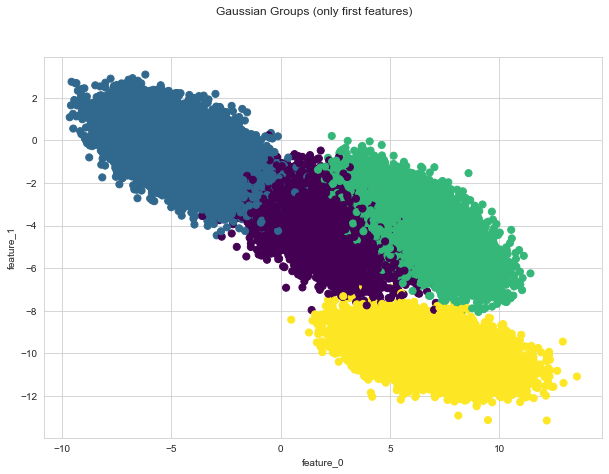

In [22]:
# Example usage:
n_samples = 100000
dim = 2
priors = [.1, .4, .2, .3]
n_groups = len(priors)
dataset_random = generate_gaussian_groups(n_groups, n_samples, dim, priors=priors)

print("sample data random:")
print(dataset_random.head())

# plot each group and color it differently
plot_gaussian_groups(dataset_random)

# Save the DataFrame to a CSV file
dataset_random.to_csv('dataset_random.csv', index=False)


#### Generate square gaussians


sample data random:
   feature_0  feature_1  label
0   2.466314  -9.368629      3
1   9.754207   1.808841      1
2 -10.904562   3.381829      0
3  10.792223   1.943182      1
4   9.106273   3.970100      1


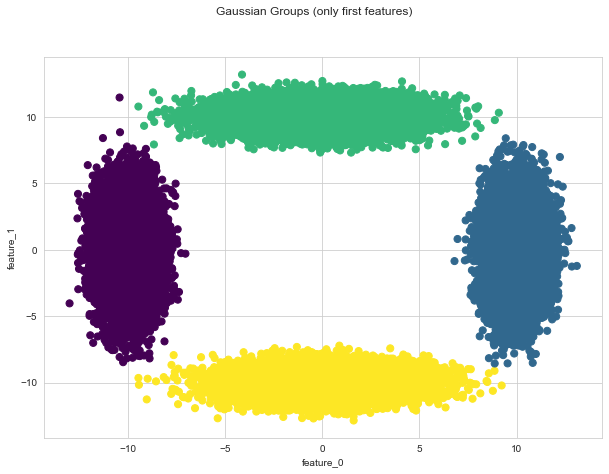

In [4]:
# Example usage:
n_samples = 100000
dim = 2
priors = [.25, .25, .25, .25]
n_groups = len(priors)
dataset_square = generate_gaussian_groups(n_groups, n_samples, dim, priors=priors,
                                   means=[np.array([-10, 0]), np.array([10, 0]), np.array([0, 10]), np.array([0, -10])],
                                   covs=[np.array([[0.5, 0], [0, 5]]), np.array([[0.5, 0], [0, 5]]), np.array([[5, 0], [0, 0.5]]), np.array([[5, 0],[0,.5]])])

print("sample data random:")
print(dataset_square.head())

# plot each group and color it differently
plot_gaussian_groups(dataset_square)

# Save the DataFrame to a CSV file
dataset_square.to_csv('dataset_square.csv', index=False)


#### Generate traingle gaussians


sample data triangle:
   feature_0  feature_1  label
0  13.277082  -1.305236      1
1  -7.102467  -6.901082      0
2   8.539768  -5.615036      1
3   0.518831   5.437602      2
4  12.993419  -1.382247      1


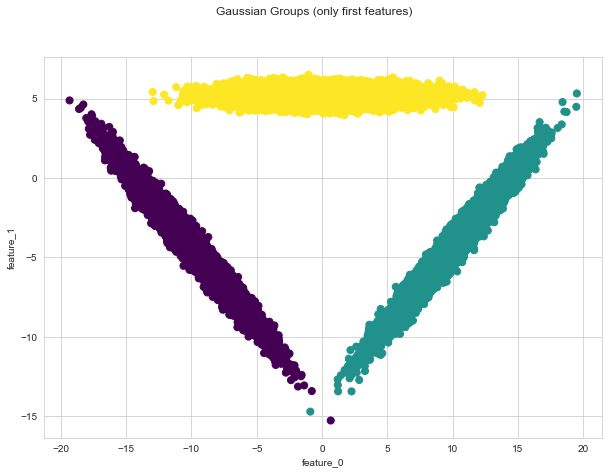

In [5]:
# Triangle
n_samples = 100000
dim = 2
priors = [1/3, 1/3, 1/3]
n_groups = len(priors)
dataset_triangle = generate_gaussian_groups(n_groups, n_samples, dim, priors=priors,
                                   means=[np.array([-10, -np.sqrt(75)/2]), np.array([10, -np.sqrt(75)/2]), np.array([0, 3*np.sqrt(3)])],
                                   covs=[np.array([[ 5.05, -4.95], [-4.95,  5.05]]), np.array([[ 5.05, 4.95], [4.95,  5.05]]), np.array([[10, 0], [0, 0.1]])])

print("sample data triangle:")
print(dataset_triangle.head())

# plot each group and color it differently
plot_gaussian_groups(dataset_triangle)

# Save the DataFrame to a CSV file
dataset_triangle.to_csv('dataset_triangle.csv', index=False)


#### Generate lines gaussians


Sample data lines:
   feature_0  feature_1  label
0   0.780634   3.479587      4
1   4.014442   3.661186      2
2   0.171477  -0.028897      0
3   2.550507   3.239284      1
4   2.216293   1.427620      1


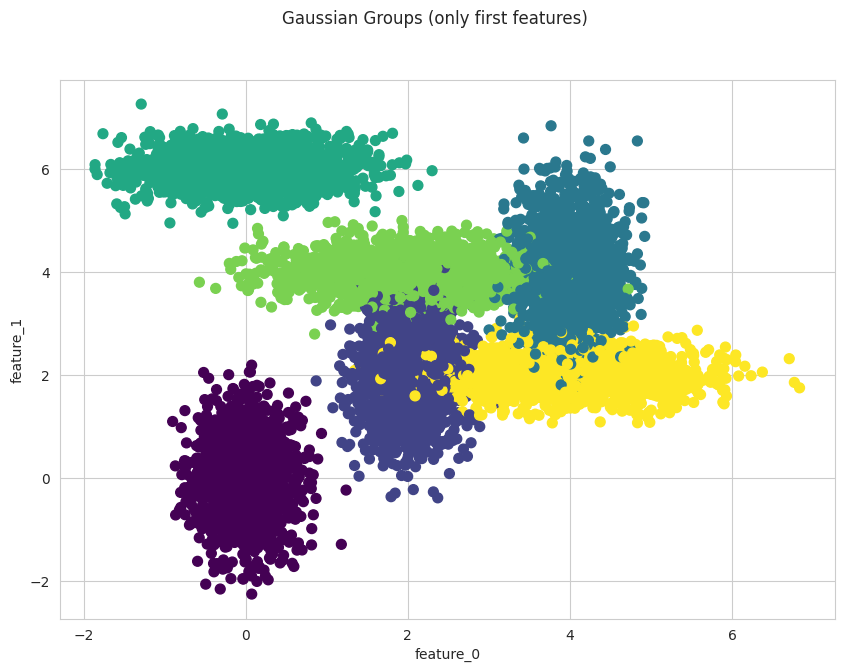

In [12]:
# Two lines with three Gaussians each
n_samples = 10000
dim = 2
priors = [1/6]*6  # Six Gaussians in total
n_groups = len(priors)

# Define the means along two lines
means = [np.array([2*i, 2*i]) for i in range(3)] + [np.array([2*i, 6-2*i]) for i in range(3)]

# Define the covariance matrices
# We can make the clusters more elongated along the lines by making one of the eigenvalues much larger than the other.
covs = [np.array([[0.1, 0], [0, 0.5+i/10]]) for i in range(3)] + [np.array([[0.5+i/10, 0], [0, 0.1]]) for i in range(3)]

# Generate the Gaussian groups
dataset_lines = generate_gaussian_groups(n_groups, n_samples, dim, priors=priors, means=means, covs=covs)

print("Sample data lines:")
print(dataset_lines.head())

# Plot each group and color it differently
plot_gaussian_groups(dataset_lines)

# Save the DataFrame to a CSV file
dataset_lines.to_csv('dataset_lines.csv', index=False)


#### Generate star gaussians

Sample data star:
   feature_0  feature_1  label
0   1.306376   4.692610      1
1  -6.489446   4.540788      2
2   3.870145 -12.171625      4
3   7.488709   0.124124      0
4  -9.485116  -6.528929      3


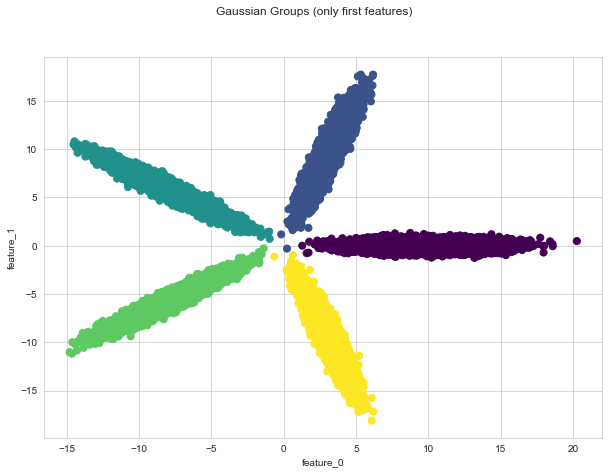

In [7]:
# Star
n_samples = 100000
dim = 2
priors = [0.2, 0.2, 0.2, 0.2, 0.2]
n_groups = len(priors)

# Define the means
means = [np.array([np.cos(2*np.pi*i/5), np.sin(2*np.pi*i/5)])*10 for i in range(5)]

# Define the covariance matrices
# We can use a similar approach to the rotated covariance matrices for the triangle,
# but with different rotation angles for each cluster to align them with the rays of the star.
covs = []
for i in range(5):
    theta = np.radians(i*72+90)  # Rotate each covariance matrix by a different angle
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    cov = np.array([[0.1, 0], [0, 5]])  # Make the clusters elongated along the rays of the star
    cov_rotated = R @ cov @ R.T
    covs.append(cov_rotated)

# Generate the Gaussian groups
dataset_star = generate_gaussian_groups(n_groups, n_samples, dim, priors=priors, means=means, covs=covs)

print("Sample data star:")
print(dataset_star.head())

# Plot each group and color it differently
plot_gaussian_groups(dataset_star)

# Save the DataFrame to a CSV file
dataset_star.to_csv('dataset_star.csv', index=False)


# Assignment #1

### Creating the algorithm of EM for GMM

In [4]:
class GMM:
    def __init__(self, n_components, n_init=1, init_method='random'):
        self.K = n_components  # Number of Gaussian components
        self.n_init = n_init  # Number of times the algorithm will be run with different initializations
        self.init_method = init_method


    def initialize(self, X, i=1, ):
        n_samples, n_features = X.shape

        if self.init_method == 'kmeans':
            # Initialize means using k-means
            kmeans = KMeans(n_clusters=self.K, random_state=0).fit(dataset[dataset.columns.drop('label')])
            self.mu = kmeans.cluster_centers_
            print(f"Means are initialized with K-Means.")
        elif self.init_method == 'random':
            # Initialize means by randomly choosing data points
            indices = np.random.choice(n_samples, size=self.K, replace=False)
            self.mu = X[indices]
        else:
            raise ValueError(f"Unknown init_method: {self.init_method}")

        # Initialize covariances to be identity matrices
        self.Sigma = np.stack([np.eye(n_features) for _ in range(self.K)])

        # Initialize priors to be uniform probabilities
        self.weights = np.full(self.K, 1 / self.K)

        print(f"Intitialization #{i}: Initialized means, covariances and weights")

    def e_step(self, X):
        n_samples = X.shape[0]

        # Compute the likelihood
        likelihood = np.zeros((n_samples, self.K))
        for i in range(self.K):
            likelihood[:, i] = multivariate_normal.pdf(X, mean=self.mu[i], cov=self.Sigma[i])

        # Compute the responsibilities using Bayes' rule
        numerator = likelihood * self.weights
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        gamma = numerator / denominator          # responsibility = prior * likelihood / evidence

        return gamma

    def m_step(self, X, gamma):
        n_samples = X.shape[0]

        # Compute the total responsibility assigned to each component
        Nk = gamma.sum(axis=0)

        # Update the means
        self.mu = np.dot(gamma.T, X) / Nk[:, np.newaxis]

        # Update the covariances
        for i in range(self.K):
            diff = X - self.mu[i]
            self.Sigma[i] = np.dot(gamma[:, i] * diff.T, diff) / Nk[i]

        # Update the weights
        self.weights = Nk / n_samples

    def fit(self, X, max_iter=1000):
        for init in range(1, 1+self.n_init):
            self.initialize(X, i=init)
            log_likelihood_old = None

            for i in tqdm(range(max_iter)):  # Maximum of 100 iterations
                # E-step
                gamma = self.e_step(X)

                # M-step
                self.m_step(X, gamma)

                # Compute the log-likelihood
                log_likelihood_new = np.sum(gamma * (np.log(self.weights) + self.log_likelihood(X)))
                if log_likelihood_old is not None and abs(log_likelihood_new - log_likelihood_old) < 1e-3:
                    print("Converged after {} iterations".format(i+1))
                    break
                log_likelihood_old = log_likelihood_new

    def log_likelihood(self, X):
        n_samples = X.shape[0]
        log_likelihood = np.zeros((n_samples, self.K))

        for i in range(self.K):
            log_likelihood[:, i] = multivariate_normal.logpdf(X, mean=self.mu[i], cov=self.Sigma[i])

        return log_likelihood

    def predict(self, X):
        # Perform the E-step with the learned parameters
        gamma = self.e_step(X)

        # Assign each data point to the component that gives it the highest responsibility
        labels = gamma.argmax(axis=1)

        return labels


### Creating the dataset

In [11]:
def split_dataset(dataset, test_size=0.2):
    # Split the dataset into training and testing sets
    if test_size:
        X_train, X_test, y_train, y_test = train_test_split(dataset.drop('label', axis=1), dataset['label'], test_size=test_size, random_state=42)
        return X_train.values, y_train.values, X_test.values, y_test.values
    else:
        X_train = dataset[dataset.columns.drop('label')]
        y_train = dataset['label']
        return X_train.values, y_train.values


### Fitting the model

In [5]:
train_predictions = {}
train_gt = {}

init_methods = ['random', 'kmeans']
datasets = ['random', 'triangle', 'square', 'lines', 'star']

for dataset_name in datasets:
    print('=' * 50)
    print("Working on dataset: ", dataset_name)
    dataset = pd.read_csv(f"dataset_{dataset_name}.csv")
    X_train, y_train = split_dataset(dataset, test_size=0)
    n_groups = len(set(y_train))
    train_predictions[dataset_name] = {}
    train_gt[dataset_name] = y_train
    for init_method in init_methods:  # number of times to fit the model
        gmm = GMM(n_components=n_groups, init_method=init_method)  # Reinitialize the GMM
        gmm.fit(X_train)
        y_train_pred = gmm.predict(X_train)
        train_predictions[dataset_name][init_method] = y_train_pred


Working on dataset:  random
Intitialization #1: Initialized means, covariances and weights


 29%|████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 288/1000 [00:01<00:04, 160.87it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Converged after 289 iterations
Means are initialized with K-Means.
Intitialization #1: Initialized means, covariances and weights


 16%|████████████████████████████████████▎                                                                                                                                                                                           | 162/1000 [00:01<00:05, 157.31it/s]


Converged after 163 iterations
Working on dataset:  triangle
Intitialization #1: Initialized means, covariances and weights


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.68it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Means are initialized with K-Means.
Intitialization #1: Initialized means, covariances and weights


  0%|▉                                                                                                                                                                                                                                  | 4/1000 [00:00<00:48, 20.62it/s]

Converged after 5 iterations


Working on dataset:  square
Intitialization #1: Initialized means, covariances and weights


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 24.14it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Means are initialized with K-Means.
Intitialization #1: Initialized means, covariances and weights


  0%|▋                                                                                                                                                                                                                                  | 3/1000 [00:00<00:55, 17.83it/s]

Converged after 4 iterations
Working on dataset:  lines


Intitialization #1: Initialized means, covariances and weights


  6%|████████████▉                                                                                                                                                                                                                     | 57/1000 [00:03<01:01, 15.31it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Converged after 58 iterations
Means are initialized with K-Means.
Intitialization #1: Initialized means, covariances and weights


  5%|███████████                                                                                                                                                                                                                       | 49/1000 [00:03<01:00, 15.59it/s]


Converged after 50 iterations
Working on dataset:  star
Intitialization #1: Initialized means, covariances and weights


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 835/1000 [00:46<00:09, 18.12it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Converged after 836 iterations
Means are initialized with K-Means.
Intitialization #1: Initialized means, covariances and weights


  0%|▍                                                                                                                                                                                                                                  | 2/1000 [00:00<01:26, 11.56it/s]

Converged after 3 iterations


### Visualizing the results

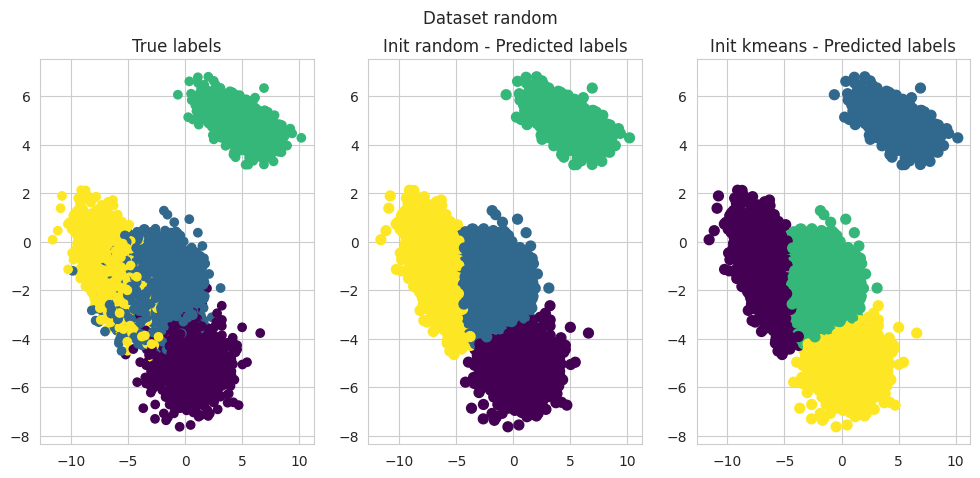

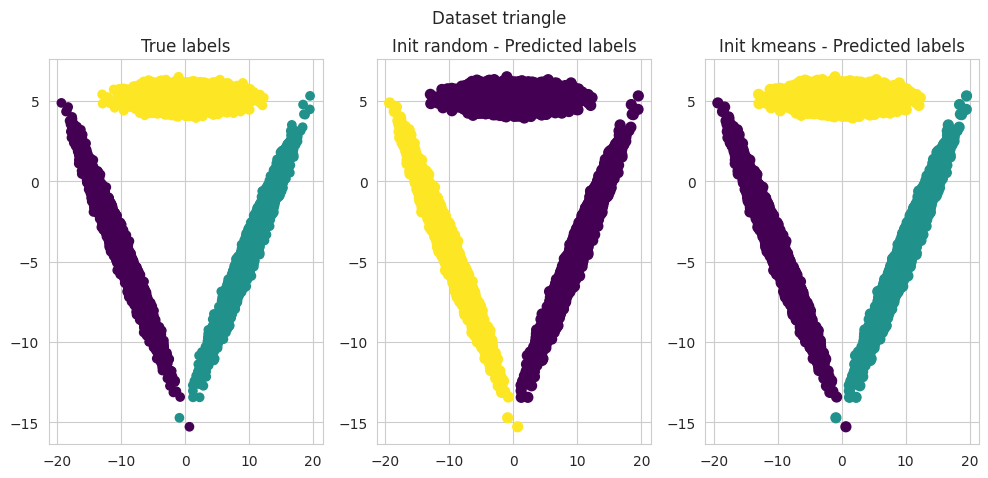

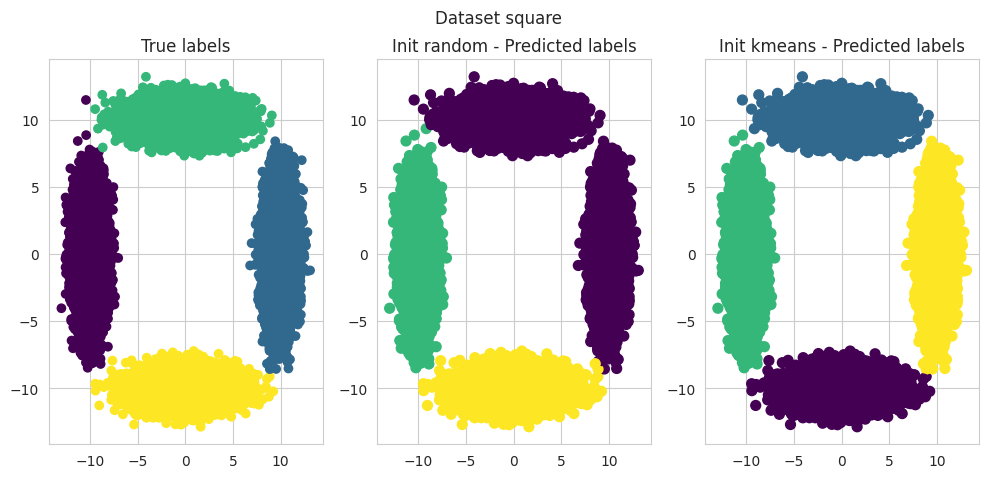

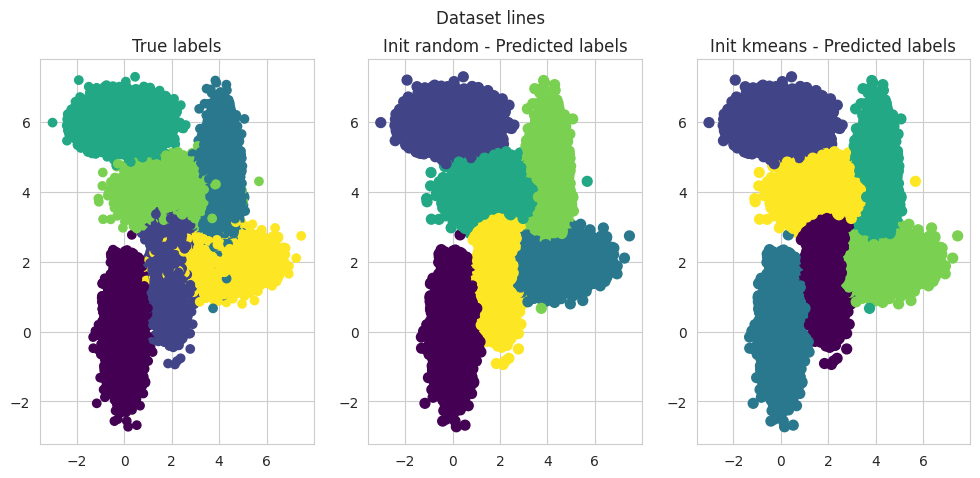

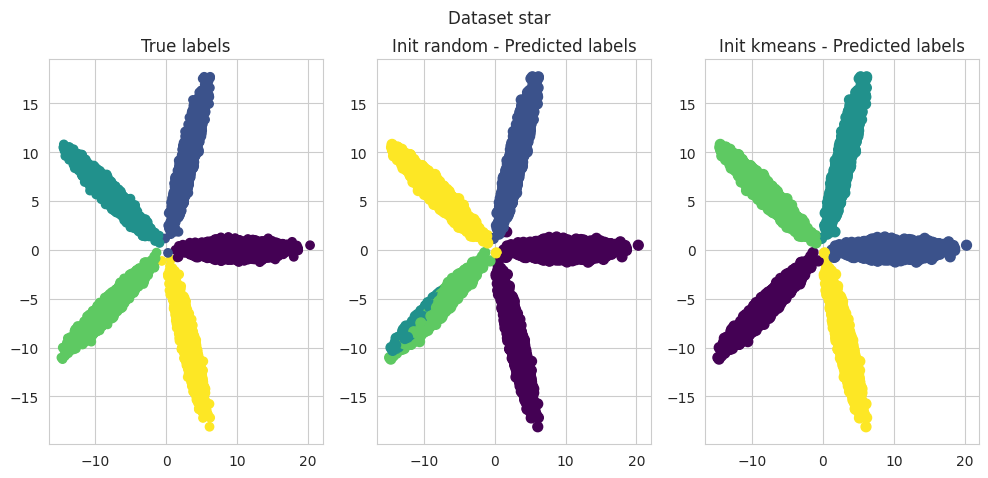

In [6]:
for dataset_name in train_predictions.keys():
    init_method = list(train_predictions[dataset_name].keys())
    fig, axs = plt.subplots(1, 1 + len(init_method), figsize=(12,5))
    dataset = pd.read_csv(f"dataset_{dataset_name}.csv")
    feat0 = dataset["feature_0"]
    feat1 = dataset["feature_1"]
    axs[0].scatter(feat0, feat1, c=train_gt[dataset_name], cmap='viridis')
    axs[0].set_title("True labels")
    for i, method in enumerate(init_method, 1):
        axs[i].scatter(feat0, feat1, c=train_predictions[dataset_name][method], s=50, cmap='viridis')
        axs[i].set_title(f"Init {method} - Predicted labels")
    fig.suptitle(f'Dataset {dataset_name}')
    plt.show()

### Evaluating the model

In [ ]:
def single_linkage(D_i, D_j):
    return np.min(np.linalg.norm(D_i[:, np.newaxis] - D_j, axis=2))

def complete_linkage(D_i, D_j):
    return np.max(np.linalg.norm(D_i[:, np.newaxis] - D_j, axis=2))

def average_linkage(D_i, D_j):
    n_i, n_j = len(D_i), len(D_j)
    return np.sum(np.linalg.norm(D_i[:, np.newaxis] - D_j, axis=2)) / (n_i * n_j)

def centroid_linkage(D_i, D_j):
    m_i, m_j = np.mean(D_i, axis=0), np.mean(D_j, axis=0)
    return np.linalg.norm(m_i - m_j)

def wards_method(D_i, D_j):
    n_i, n_j = len(D_i), len(D_j)
    m_i, m_j = np.mean(D_i, axis=0), np.mean(D_j, axis=0)
    return np.sqrt((n_i * n_j) / (n_i + n_j)) * np.linalg.norm(m_i - m_j)

#TODO: what is the last method?

# Assignment #2

In [26]:
class WFKM:
    def __init__(self, X, P, K):
        self.M = len(X)         # number of data points
        self.u = np.ones((self.M, K))    # membership matrix
        self.K = K              # number of prototypes = CLUSTERS
        self.X = X
        self.P = P.copy()
        self.q = 2

    def find_prototypes(self, max_iter=100):
        # X is the data matrix
        # K is the number of prototypes
        # P is the previous centers (prototypes) matrix - length K
        eps = 0.01

        for iter in tqdm(range(max_iter)):
            self.iter = iter
            u_prev = self.u.copy()

            # calculate membership matrix u
            for k in range(self.K):
                inverse_d_K_len = self._inverse_distances(k)
                self.u[:, k] = inverse_d_K_len[:, k] / inverse_d_K_len.sum(axis=-1)

            self.P = np.array([np.sum((self.u[:, k] ** 2)[:, None] * self.X, axis=0)
                               / np.sum(self.u[:, k] ** 2) for k in range(self.K)])

            # break if the condition is met
            if not self.cond(self.u, u_prev, eps):
                break

        self.D = self.distances(self.X, self.P)

        return self.P, self.u, self.D

    def _inverse_distances(self, k):
        if self.iter == 0 and k > 0 and k == self.K - 1:
            distances_k_len = np.ones((len(self.X), self.K)) * (10 * np.sum(np.var(self.X.T, axis=0, ddof=1)))      # (10 * np.trace(np.cov(self.X)))
        else:
            distances_k_len = self.distances(self.X, self.P)    # euclidian distance
        inverse_d_k_len = np.where(distances_k_len, (1e-7 + distances_k_len) ** (1 / (1 - self.q)), 0)
        return inverse_d_k_len

    def distances(self, X, P):
        return np.sum((P[None, :, :] - X[:, None, :]) ** 2, axis=-1)


    def cond(self, u, u_prev, eps=0.01):
        if u_prev is None:
            return True
        else:
            return np.linalg.norm(u - u_prev) > eps


class WUOFC:
    def __init__(self, ):
        self.evaluation_results = dict()
        self.clustering_results = dict()
        self.models = dict()
        self.q = 2

    def fit(self, X, max_K):
        P_init = X.mean(axis=0)[None, :]
        for K in range(1, max_K+1):
            print(f'Cluster size - K = {K}')
            # init wfkm with K clusters
            wfkm = WFKM(X, P_init, K)
            # find prototypes
            P, U, D = wfkm.find_prototypes(max_iter=100)

            # calculate metrics
            self.evaluation_results[K] = self.metrics(X, P, U, D, K)
            self.clustering_results[K] = self.predict(U)
            self.models[K] = wfkm

            # creating the new center
            P_init = np.concatenate((P_init,
                                     np.array(X[np.unravel_index(U.argmin(), U.shape)[0]])[None, :]))

        return self.evaluation_results, self.clustering_results

    def predict(self, U):
        return np.argmax(U, axis=1)

    def _F_calculate(self, U, X, P):
        # Compute F for each data point and each cluster
        # Reshape X, prototypes, and memberships to allow broadcasting
        X_reshaped = X[:, None, :]
        P_reshaped = P[None, :, :]
        U_reshaped = U[:, :, None, None]

        # Compute the difference and outer product for each pair of data point and prototype
        diff = (P_reshaped - X_reshaped)[:, :, :, None]
        F_k = diff @ diff.transpose(0, 1, 3, 2)

        # Compute the weighted sum of F_k for each cluster
        F = np.sum(U_reshaped * F_k, axis=0)

        # Compute the sum of memberships for each cluster
        sum_dominator_k = U.sum(axis=0)

        # Normalize F by the sum of memberships
        F /= sum_dominator_k[:, None, None]

        return F

    def _central_members_Ik(self, X, Pk, Fk):
        I = []
        Gk = np.linalg.inv(Fk)
        for i in range(X.shape[0]):
            sample_i_valid = True
            for j in range(X.shape[1]):
                cond = (Pk - X[i]) @ Gk[j] * (Pk[j] - X[i, j]) < 1
                if not cond:
                    sample_i_valid = False
                    break
            if sample_i_valid:
                I.append(i)
        return I

    def _maximal_members_Jk(self, U, k):
        J = []
        for i in range(len(U)):
            if U[i, k] == np.max(U[i, :]):
                J.append(i)
        return J

    def _Ck_calculate(self, X, Uk, Pk, Fk):
        Ik = self._central_members_Ik(X, Pk, Fk)
        return np.take(Uk, Ik).sum()

    def _Mk_calculate(self, U, k):
        Jk = self._maximal_members_Jk(U, k)
        return np.take(U[:, k], Jk).sum()

    def _invariant_calculate(self, X, P, U, F, K):
        S_w = np.sum(F, axis=0)
        mu = np.mean(X, axis=0)
        clusters = np.argmax(U, axis=1)
        S_b = sum([list(clusters).count(k) * (P[k] - mu).reshape(-1, 1) @ (P[k] - mu).reshape(-1, 1).T for k in range(K)])
        return np.trace(np.linalg.inv(S_w) @ S_b)

    def metrics(self,X, P, U, D, K):
        print('Calculating metrics...')
        F = self._F_calculate(U, X, P)
        # calculating C_k with the group of central members of each cluster
        C_k = [self._Ck_calculate(X, U[:, k], P[k], F[k]) for k in range(K)]
        # calculating M_k with the group of maximal members of each cluster
        M_k = [self._Mk_calculate(U, k) for k in range(K)]
        # calculating H_k - the hypervolume of each cluster
        H_k = [np.linalg.det(F[k]) ** .5 for k in range(K)]
        # hyper volume criteria
        hypervolume = np.sum(H_k)
        # partition density criteria
        partition_density = np.sum(C_k) / hypervolume
        # average partition density central criteria
        avg_pd_central = np.divide(C_k, H_k).mean()
        # average partition density max criteria
        avg_pd_max = np.divide(M_k, H_k).mean()
        # normalized partition criteria
        normalized_partition = np.einsum('mk,mk->k', D, U ** self.q).sum() * K
        # invariant criteria
        invariant = self._invariant_calculate(X, P, U, F, K)
        return {
            'hv': hypervolume,
            'pd': partition_density,
            'apd_central': avg_pd_central,
            'apd_max': avg_pd_max,
            'np': normalized_partition,
            'inv': invariant
        }

### Fitting the model

In [40]:

datasets = ['random', 'triangle', 'square', 'lines', 'star']
max_clusters = 10

for dataset_name in datasets:
    print('=' * 50)
    print("Working on dataset: ", dataset_name)
    dataset = pd.read_csv(f"dataset_{dataset_name}.csv")
    X_train, y_train = split_dataset(dataset, test_size=0)

    train_predictions[dataset_name] = {}
    train_gt[dataset_name] = y_train

    print('Fitting the model with max clusters of ', max_clusters)
    woufc = WUOFC()   # Initialize the WOUFC
    metrics, clustering = woufc.fit(X_train, max_K=max_clusters)

    train_predictions[dataset_name]['metrics'] = metrics
    train_predictions[dataset_name]['pred'] = clustering
    train_predictions[dataset_name]['model'] = woufc

Working on dataset:  random
Fitting the model with max clusters of  10
Cluster size - K = 1


  0%|                                                                                                                                                                                                                                            | 0/100 [00:00<?, ?it/s]


Calculating metrics...
Cluster size - K = 2


 10%|██████████████████████▌                                                                                                                                                                                                           | 10/100 [00:00<00:00, 130.87it/s]

Calculating metrics...


Cluster size - K = 3


 16%|████████████████████████████████████▏                                                                                                                                                                                             | 16/100 [00:00<00:00, 383.50it/s]

Calculating metrics...


Cluster size - K = 4


 32%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 32/100 [00:00<00:00, 144.84it/s]


Calculating metrics...
Cluster size - K = 5


 37%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 37/100 [00:00<00:00, 183.02it/s]


Calculating metrics...
Cluster size - K = 6


 41%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 41/100 [00:00<00:00, 144.97it/s]


Calculating metrics...
Cluster size - K = 7


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 89/100 [00:01<00:00, 54.25it/s]


Calculating metrics...
Cluster size - K = 8


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 91/100 [00:01<00:00, 63.39it/s]


Calculating metrics...
Cluster size - K = 9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.96it/s]


Calculating metrics...
Cluster size - K = 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.59it/s]


Calculating metrics...
Working on dataset:  triangle
Fitting the model with max clusters of  10
Cluster size - K = 1


  0%|                                                                                                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

Calculating metrics...


Cluster size - K = 2


 20%|█████████████████████████████████████████████▏                                                                                                                                                                                    | 20/100 [00:00<00:00, 103.96it/s]

Calculating metrics...


Cluster size - K = 3


  9%|████████████████████▌                                                                                                                                                                                                               | 9/100 [00:00<00:01, 48.71it/s]

Calculating metrics...


Cluster size - K = 4


 32%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 32/100 [00:01<00:02, 30.62it/s]


Calculating metrics...
Cluster size - K = 5


 31%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 31/100 [00:01<00:03, 19.97it/s]


Calculating metrics...
Cluster size - K = 6


 32%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 32/100 [00:02<00:05, 12.72it/s]


Calculating metrics...
Cluster size - K = 7


 36%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 36/100 [00:03<00:07,  9.13it/s]


Calculating metrics...
Cluster size - K = 8


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 45/100 [00:05<00:07,  7.67it/s]


Calculating metrics...
Cluster size - K = 9


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 54/100 [00:08<00:07,  6.56it/s]


Calculating metrics...
Cluster size - K = 10


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 60/100 [00:10<00:07,  5.49it/s]


Calculating metrics...
Working on dataset:  square
Fitting the model with max clusters of  10
Cluster size - K = 1


  0%|                                                                                                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

Calculating metrics...


Cluster size - K = 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 111.42it/s]


Calculating metrics...
Cluster size - K = 3


 37%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 37/100 [00:00<00:01, 52.67it/s]


Calculating metrics...
Cluster size - K = 4


 10%|██████████████████████▋                                                                                                                                                                                                            | 10/100 [00:00<00:03, 28.50it/s]


Calculating metrics...
Cluster size - K = 5


 25%|████████████████████████████████████████████████████████▊                                                                                                                                                                          | 25/100 [00:01<00:03, 21.21it/s]


Calculating metrics...
Cluster size - K = 6


 27%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 27/100 [00:01<00:05, 14.54it/s]


Calculating metrics...
Cluster size - K = 7


 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 46/100 [00:04<00:05,  9.95it/s]


Calculating metrics...
Cluster size - K = 8


 39%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 39/100 [00:05<00:07,  7.77it/s]


Calculating metrics...
Cluster size - K = 9


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 89/100 [00:13<00:01,  6.60it/s]


Calculating metrics...
Cluster size - K = 10


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 92/100 [00:16<00:01,  5.65it/s]


Calculating metrics...
Working on dataset:  lines
Fitting the model with max clusters of  10
Cluster size - K = 1


  0%|                                                                                                                                                                                                                                            | 0/100 [00:00<?, ?it/s]


Calculating metrics...
Cluster size - K = 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 781.03it/s]


Calculating metrics...
Cluster size - K = 3


 27%|█████████████████████████████████████████████████████████████                                                                                                                                                                     | 27/100 [00:00<00:00, 335.48it/s]

Calculating metrics...


Cluster size - K = 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 304.80it/s]


Calculating metrics...
Cluster size - K = 5


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 46/100 [00:00<00:00, 190.00it/s]


Calculating metrics...
Cluster size - K = 6


 18%|████████████████████████████████████████▋                                                                                                                                                                                         | 18/100 [00:00<00:00, 135.81it/s]

Calculating metrics...


Cluster size - K = 7


 25%|████████████████████████████████████████████████████████▌                                                                                                                                                                         | 25/100 [00:00<00:00, 113.35it/s]


Calculating metrics...
Cluster size - K = 8


 35%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 35/100 [00:00<00:00, 89.44it/s]


Calculating metrics...
Cluster size - K = 9


 42%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 42/100 [00:00<00:00, 72.27it/s]


Calculating metrics...
Cluster size - K = 10


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 45/100 [00:00<00:00, 58.58it/s]


Calculating metrics...
Working on dataset:  star
Fitting the model with max clusters of  10
Cluster size - K = 1


  0%|                                                                                                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

Calculating metrics...


Cluster size - K = 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 107.14it/s]


Calculating metrics...
Cluster size - K = 3


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 89/100 [00:01<00:00, 53.59it/s]


Calculating metrics...
Cluster size - K = 4


 25%|████████████████████████████████████████████████████████▊                                                                                                                                                                          | 25/100 [00:00<00:02, 31.01it/s]


Calculating metrics...
Cluster size - K = 5


 14%|███████████████████████████████▊                                                                                                                                                                                                   | 14/100 [00:00<00:04, 19.86it/s]


Calculating metrics...
Cluster size - K = 6


 30%|████████████████████████████████████████████████████████████████████                                                                                                                                                               | 30/100 [00:02<00:04, 14.36it/s]


Calculating metrics...
Cluster size - K = 7


 30%|████████████████████████████████████████████████████████████████████                                                                                                                                                               | 30/100 [00:02<00:06, 10.70it/s]


Calculating metrics...
Cluster size - K = 8


 29%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 29/100 [00:03<00:08,  8.09it/s]


Calculating metrics...
Cluster size - K = 9


 27%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 27/100 [00:04<00:11,  6.36it/s]


Calculating metrics...
Cluster size - K = 10


 32%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 32/100 [00:05<00:12,  5.38it/s]


Calculating metrics...


### Visualizing the results

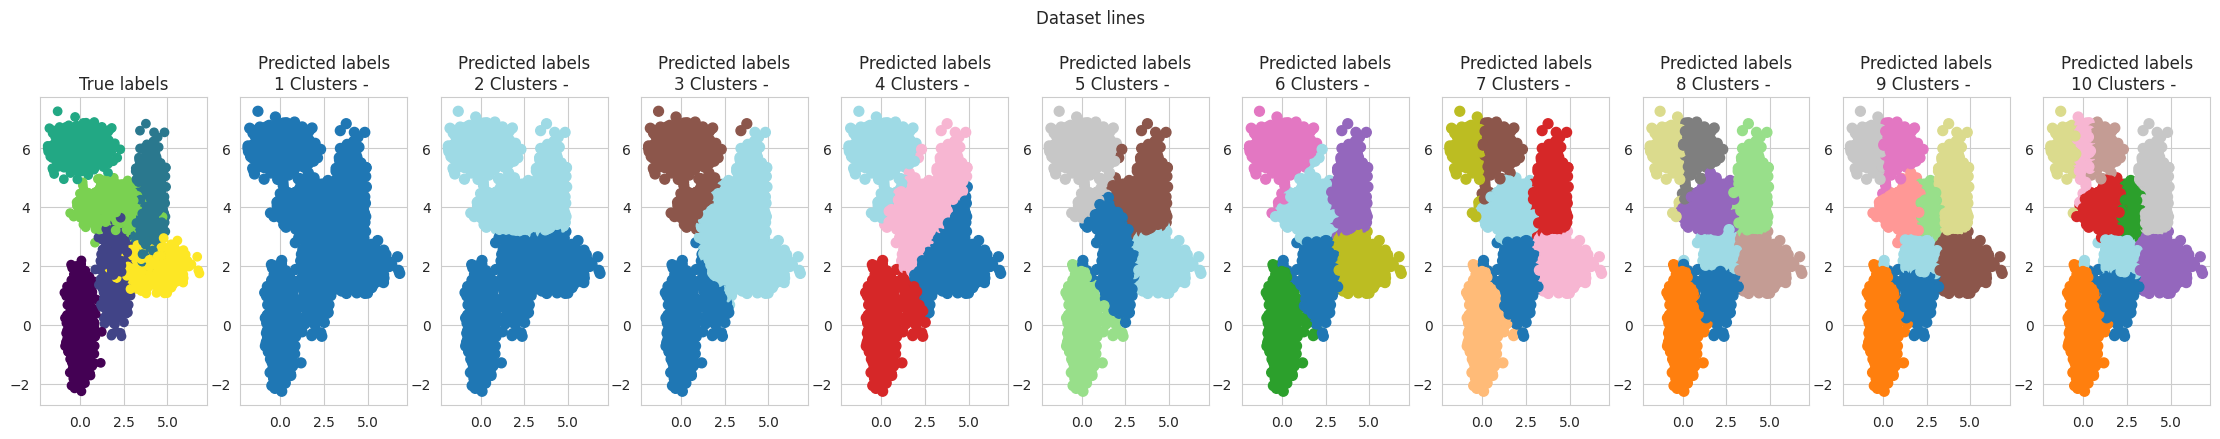

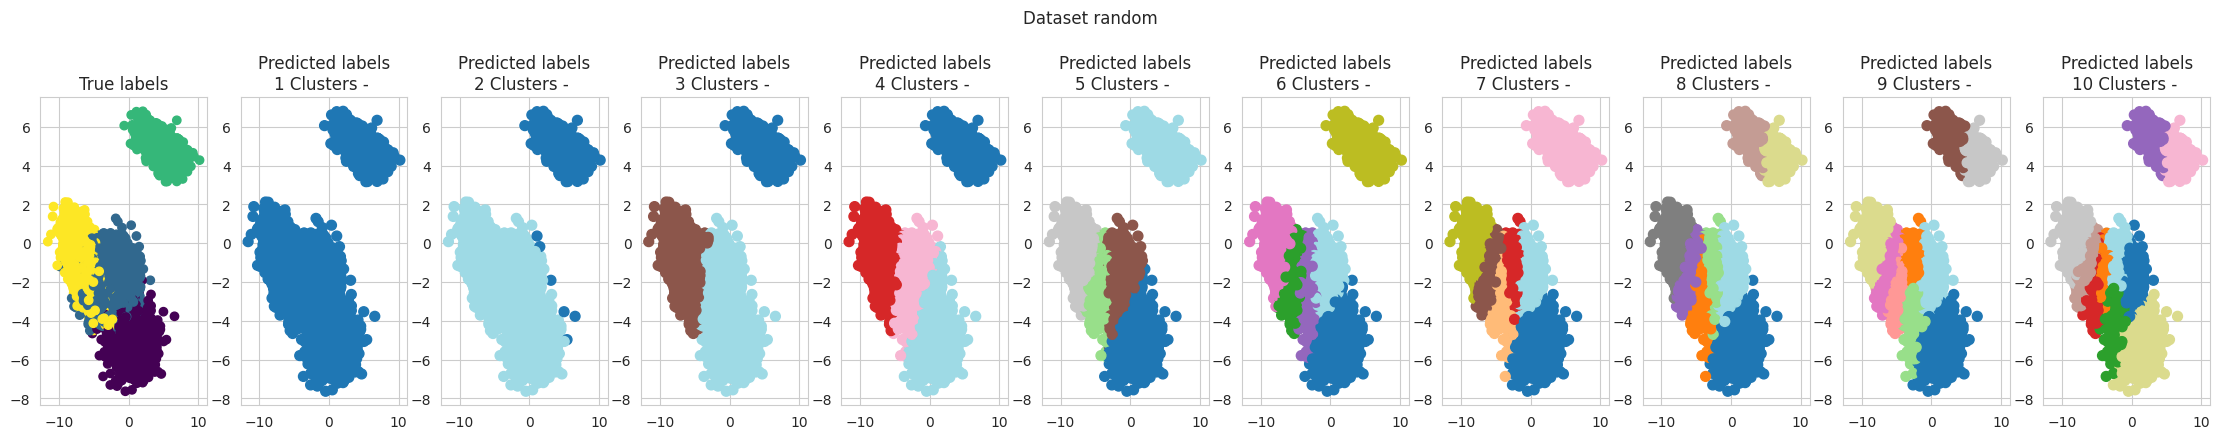

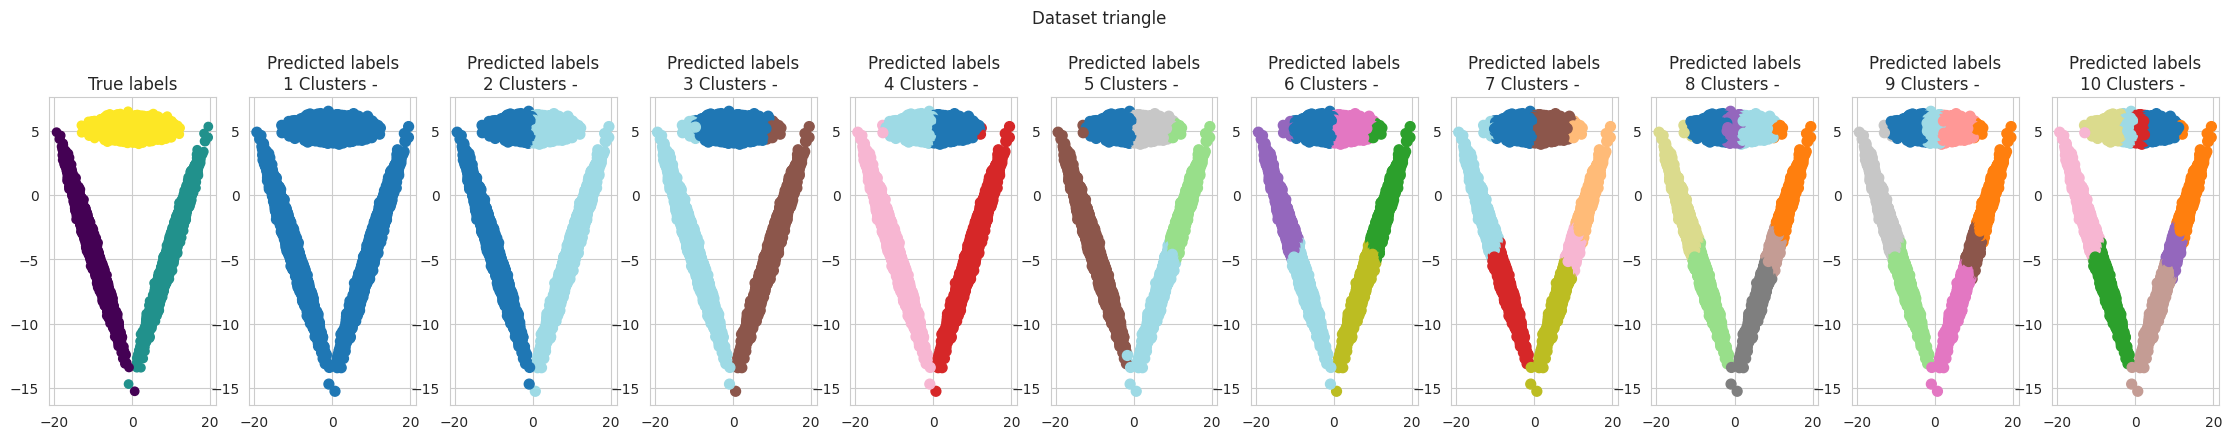

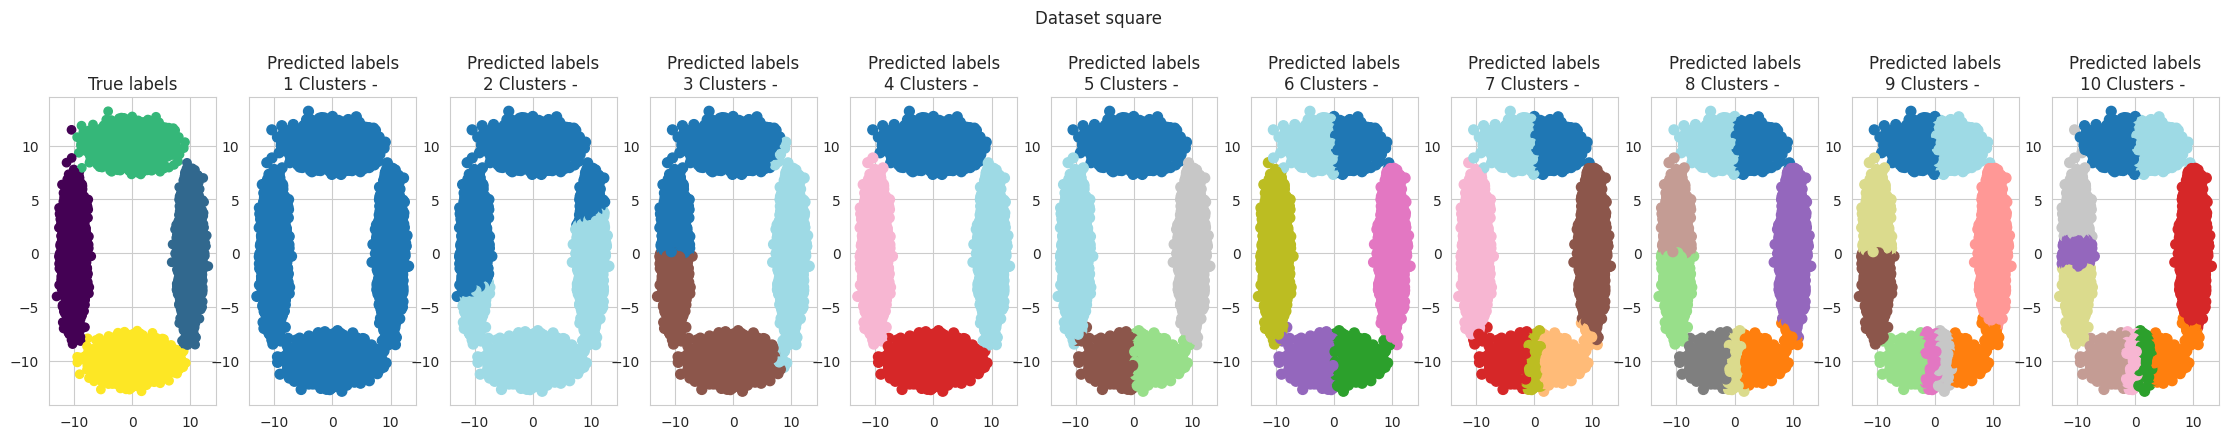

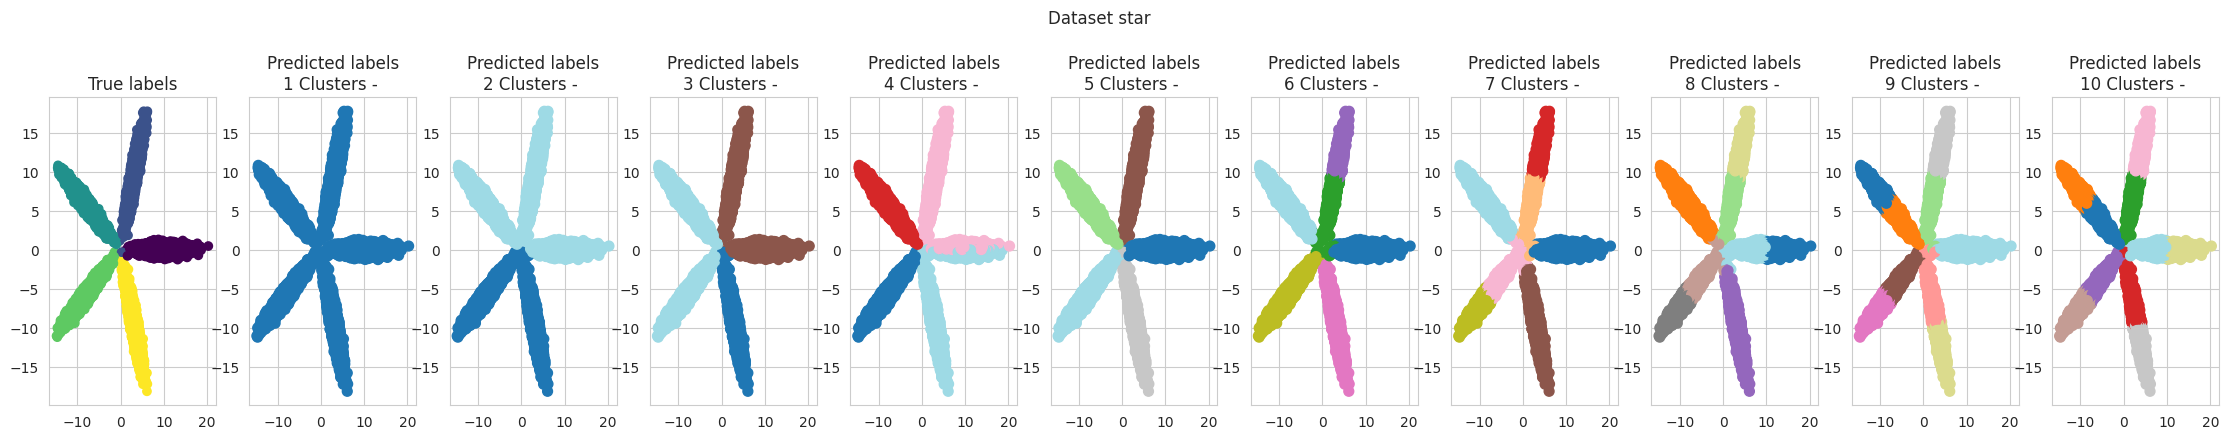

In [49]:
for dataset_name in train_predictions.keys():
    init_methods = list(train_predictions[dataset_name].keys())
    dataset = pd.read_csv(f"dataset_{dataset_name}.csv")
    feat0 = dataset["feature_0"]
    feat1 = dataset["feature_1"]
    n_clusters = [k for k in train_predictions[dataset_name]['pred'].keys() if type(k) == int]
    fig, axs = plt.subplots(1, 1 + len(n_clusters), figsize=(28,4))
    axs[0].scatter(feat0, feat1, c=train_gt[dataset_name], cmap='viridis')
    axs[0].set_title("True labels")
    for i, n_cluster in enumerate(n_clusters, 1):
        axs[i].scatter(feat0, feat1, c=train_predictions[dataset_name]['pred'][n_cluster], s=50, cmap='tab20')
        axs[i].set_title(f"Predicted labels\n{n_cluster} Clusters - ")
    fig.suptitle(f'Dataset {dataset_name}', y=1.1)
    plt.show()


### Evaluating the results by 6 criteria

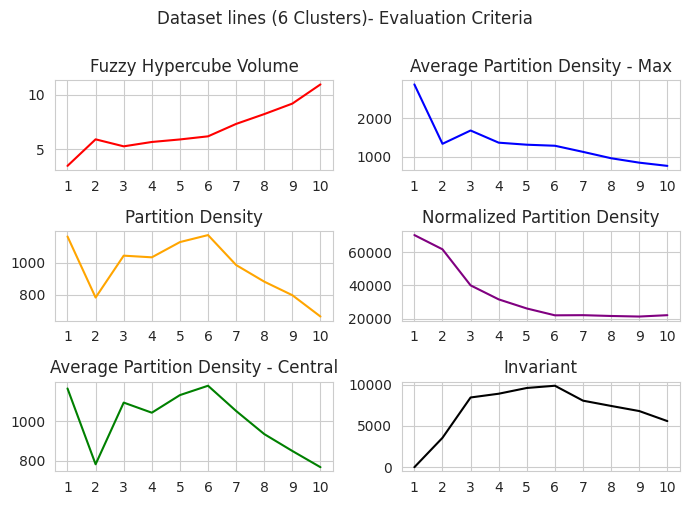

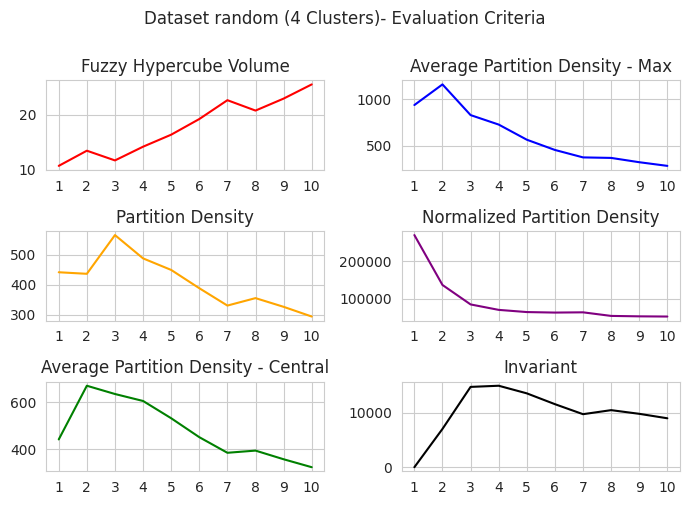

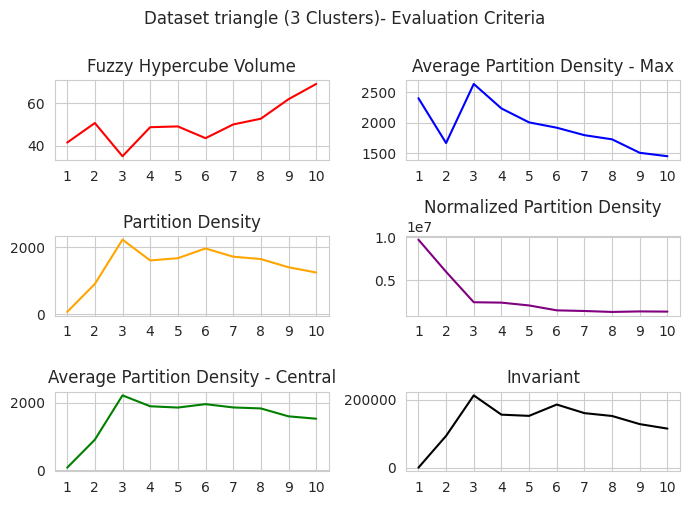

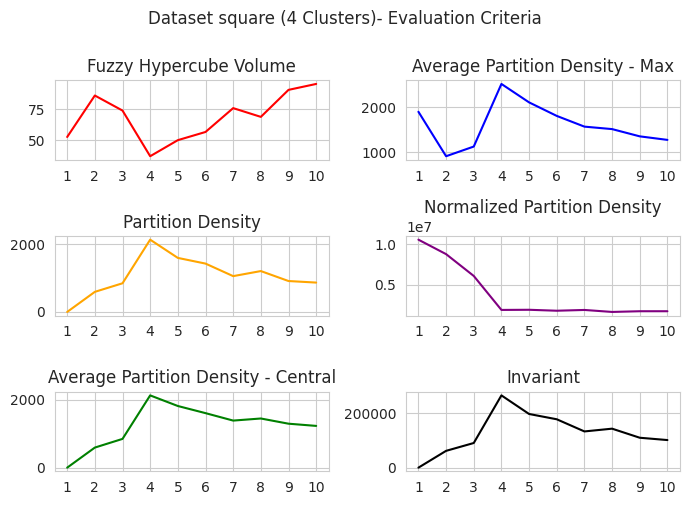

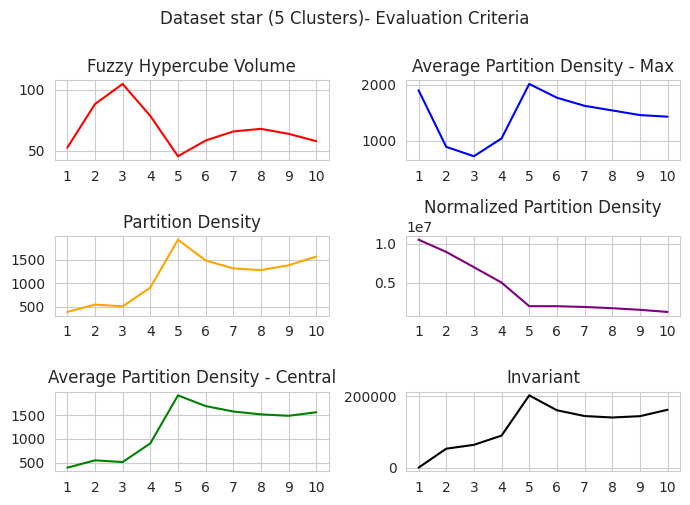

In [45]:
# for each dataset_name, init_method - plot the 6 criteria from uofc object for each n_groups as a line graph
for dataset_name in train_predictions.keys():
    init_methods = list(train_predictions[dataset_name].keys())
    dataset = pd.read_csv(f"dataset_{dataset_name}.csv")
    X = dataset[dataset.columns.drop('label')].values
    gt_clusters = len(dataset['label'].unique())
    n_clusters = [k for k in train_predictions[dataset_name]['pred'].keys() if type(k) == int]

    fig, axs = plt.subplots(3, 2, figsize=(7, 5))
    hvs = []
    pds = []
    apd_cs = []
    apd_ms = []
    norm_ps = []
    inv = []
    for k in n_clusters:
        hvs.append(train_predictions[dataset_name]['metrics'][k]['hv'])
        pds.append(train_predictions[dataset_name]['metrics'][k]['pd'])
        apd_cs.append(train_predictions[dataset_name]['metrics'][k]['apd_central'])
        apd_ms.append(train_predictions[dataset_name]['metrics'][k]['apd_max'])
        norm_ps.append(train_predictions[dataset_name]['metrics'][k]['np'])
        inv.append(train_predictions[dataset_name]['metrics'][k]['inv'])
    # plot as a line
    axs[0, 0].set_title("Fuzzy Hypercube Volume")
    axs[0, 0].plot(n_clusters, hvs, linestyle='-', color='red')
    axs[0, 0].set_xticks(range(1, max_clusters + 1))
    axs[1, 0].set_title("Partition Density")
    axs[1, 0].plot(n_clusters, pds, linestyle='-', color='orange')
    axs[1, 0].set_xticks(range(1, max_clusters + 1))
    axs[2, 0].set_title("Average Partition Density - Central")
    axs[2, 0].plot(n_clusters, apd_cs, linestyle='-', color='green')
    axs[2, 0].set_xticks(range(1, max_clusters + 1))
    axs[0, 1].set_title("Average Partition Density - Max")
    axs[0, 1].plot(n_clusters, apd_ms, linestyle='-', color='blue')
    axs[0, 1].set_xticks(range(1, max_clusters + 1))
    axs[1, 1].set_title("Normalized Partition Density")
    axs[1, 1].plot(n_clusters, norm_ps, linestyle='-', color='purple')
    axs[1, 1].set_xticks(range(1, max_clusters + 1))
    axs[2, 1].set_title("Invariant")
    axs[2, 1].plot(n_clusters, inv, linestyle='-', color='black')
    axs[2, 1].set_xticks(range(1, max_clusters + 1))
    fig.suptitle(f'Dataset {dataset_name} ({gt_clusters} Clusters)- Evaluation Criteria', y=1)
    plt.tight_layout()
    plt.show()

# Assignment 3

In [ ]:
def cdist(D_i, D_j, type='euclidean'):
    if type == 'euclidean':
        return distance_matrix(D_i, D_j)
    else:
        raise NotImplemented

def distances(D_i, D_j, mode='d_min'): #distnces from p.54 + p.56
    if mode == 'd_mean':
        return np.linalg.norm(np.mean(D_i, axis=0) - np.mean(D_j, axis=0))
    elif mode == 'd_e':
        n_i = len(D_i)
        n_j = len(D_j)
        return np.sqrt((n_i * n_j) / n_i + n_j) * np.linalg.norm(np.mean(D_i, axis=0) - np.mean(D_j, axis=0))

    else:
        distance_matrix = cdist(D_i, D_j, 'euclidean')

        if mode == 'd_min':
            return np.min(distance_matrix)
        elif mode == 'd_max':
            return np.max(distance_matrix)
        elif mode == 'd_avg':
            return np.sum(distance_matrix) / (len(D_i) * len(D_j))


def ah_clustering(X, n_clusters, dis_mode, dis_max=-1): #algorithm from p.54
    n = X.shape[0]  # Number of data points
    c_hat = n  # Initial number of clusters
    clusters = [[i] for i in range(n)]  # Initialize each data point as a separate cluster

    if n_clusters == None: #number of clusters if unknown:
        n_clusters = 1

    while c_hat > n_clusters:
        print(f"number of clusters to aggregate - {c_hat}")
        nearest_distance = np.inf
        nearest_i = None
        nearest_j = None

        # Find the nearest clusters
        for i in range(c_hat):
            for j in range(i + 1, c_hat):
                distance = distances(X[clusters[i]], X[clusters[j]], mode=dis_mode)
                if distance < nearest_distance:
                    nearest_distance = distance
                    nearest_i = i
                    nearest_j = j

        if n_clusters==1 and nearest_distance > dis_max: #number of clusters is unknown
            break

        # Merge the nearest clusters
        clusters[nearest_i] += clusters[nearest_j]
        del clusters[nearest_j]
        c_hat -= 1

    return clusters


def so_clustering(X, n_clusters, dis_mode, change_max=-1): # algorithm from p.56
    n = X.shape[0]  # Number of data points
    c_hat = n  # Initial number of clusters
    clusters = [[i] for i in range(n)]  # Initialize each data point as a separate cluster

    if n_clusters == None: #number of clusters if unknown:
        n_clusters = 1

    while c_hat > n_clusters:
        min_change = np.inf
        nearest_i = None
        nearest_j = None

        # Find clusters whose merger changes the criterion the least
        for i in range(c_hat):
            for j in range(i + 1, c_hat):
                criterion_change = compute_criterion_change(X[clusters[i]], X[clusters[j]])
                if criterion_change < min_change:
                    min_change = criterion_change
                    nearest_i = i
                    nearest_j = j

        if n_clusters==1 and min_change > change_max: #number of clusters is unknown
            break

        # Merge the clusters with the least criterion change
        clusters[nearest_i] += clusters[nearest_j]
        del clusters[nearest_j]
        c_hat -= 1

    return clusters


def compute_criterion_change(Di, Dj):

    return 0


In [14]:
train_predictions = {}
train_gt = {}
dis_max = 0.01      # tol to stop Agglomerative hierarchical
change_max = 0.01   # tol to stop Stepwise optimal hierarchical

datasets = ['random'] # , 'triangle', 'square', 'lines', 'star']

for dataset_name in datasets:
    print('=' * 50)
    print("Working on dataset: ", dataset_name)
    dataset = pd.read_csv(f"dataset_{dataset_name}.csv")
    X_train, y_train = split_dataset(dataset, test_size=0)
    n_clusters = len(set(train_gt))
    train_predictions[dataset_name] = {}
    train_gt[dataset_name] = y_train

    for known_num_of_clusters in [n_clusters, None]:
        if known_num_of_clusters:
            print(f"\tKnowning the number of clusters - {known_num_of_clusters}")
        for dist_mode in ['d_min', 'd_max', 'd_avg', 'd_mean', 'd_e']:
            print(f"\tDistance mode - {dist_mode}")
            # Agglomerative hierarchical clustering
            ah_clusters = ah_clustering(X=X_train, n_clusters=known_num_of_clusters, dis_mode=dist_mode, dis_max=dis_max)
            ah_acc = metrics.rand_score(labels_true=train_gt, labels_pred=ah_clusters)
            # Stepwise optimal hierarchical clustering
            # so_clusters = so_clustering(X=X_train,n_clusters=known_num_of_clusters,dis_mode=dist_mode, change_max=change_max)
            # so_acc = metrics.rand_score(labels_true=train_gt, labels_pred=so_clusters)

            print(f'For {known_num_of_clusters} known clusters and dist_mode={dist_mode} - AHC: { ah_acc:.2%}, SOC: {so_acc :.2%}')

    print('done')



Working on dataset:  random
	Distance mode - d_min



KeyboardInterrupt

